# Preamble

In [1]:
# Run once to allow imports
%cd ..
%load_ext autoreload
%autoreload 2

/Users/lena/modconn/harvard_cs282_ptg


In [122]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import datasets
from datasets.tabular import TabularModelPerturb
from datasets import get_model_class
from util import get_weight_norm, get_weight_diff
from style import plot_grads, bold
from similarity import get_top_k, average_pairwise_score, top_k_sa
from similarity import average_ground_truth_score, ground_truth_score

In [3]:
random_sources = ['rs', 'loo']
random_source = random_sources[0]
print(bold("Source of Randomness:"), random_source)

Source of Randomness: rs


In [52]:
name = 'heloc'  # or 'german'
n_models = 1000  # 1000 for german if needed
trainset, testset = datasets.load_dataset(name)

X_test, y_test = testset.data.numpy(), testset.labels.numpy()
n_inputs, n_features = X_test.shape
model_args = [n_features, datasets.tabular.layers[name]]
model_class = get_model_class(name)
optim = 'sgd'
epochs = 20
lr = 0.1
batch_size = 64
dropout = 0
directory = f'models/{name}/{random_source}/{optim}_epochs{epochs}_lr{lr}_batch{batch_size}_dropout{dropout}'
print(bold("Directory:"), directory)

def load_model(idx):
    model_class = get_model_class(name)
    model = model_class(*model_args)
    state_dict = torch.load(f'{directory}/model_{idx}.pth')
    model.load_state_dict(state_dict)
    return model

Directory: models/heloc/rs/sgd_epochs20_lr0.1_batch64_dropout0


# First Layer Weight Norms

(128, 23)


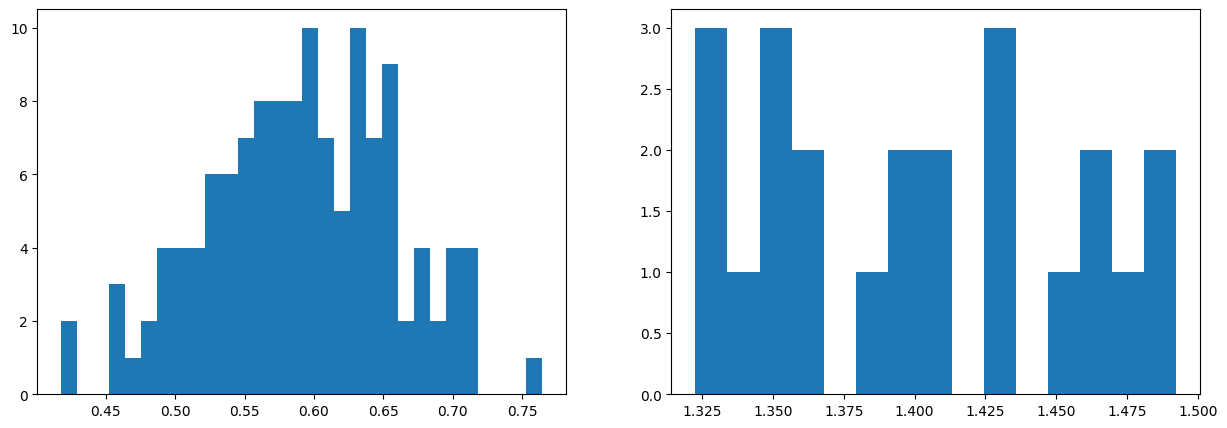

In [8]:
model = load_model(0)
first_layer = model.state_dict()['network.0.weight'].numpy()
print(first_layer.shape)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=100)
ax[0].hist(np.linalg.norm(first_layer, axis=1), bins=30)
ax[1].hist(np.linalg.norm(first_layer, axis=0), bins=15)
plt.show()

# One model, Gaussian noise (mean = 0, std. dev = sigma) on first layer

In [9]:
model = load_model(0)
original_grads = model.compute_gradients(X_test, softmax=False, label=1, return_numpy=True)
original_preds = model.predict(X_test, return_numpy=True)

In [13]:
n_samples = 1000
sigma = 0.01
pert_model = TabularModelPerturb(model, n_samples, sigma)
pert_grads = pert_model.compute_gradients(X_test, mean=False)
pert_preds = pert_model.predict(X_test, mean=False)
pert_preds.shape

(1000, 1975)

### Perturbation Predictions

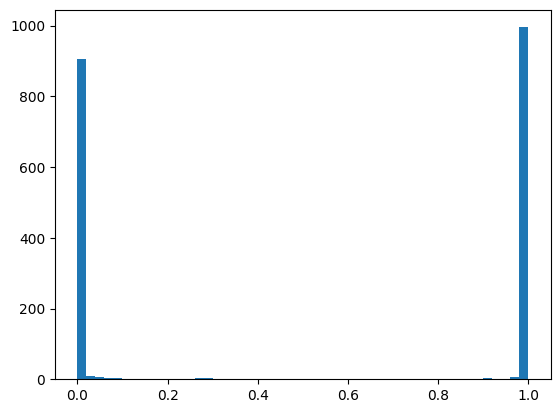

In [15]:
plt.hist(pert_preds.mean(axis=0), bins=50)
plt.show()

### Perturbation Gradients

In [18]:
pert_grads.shape

(1000, 1975, 23)

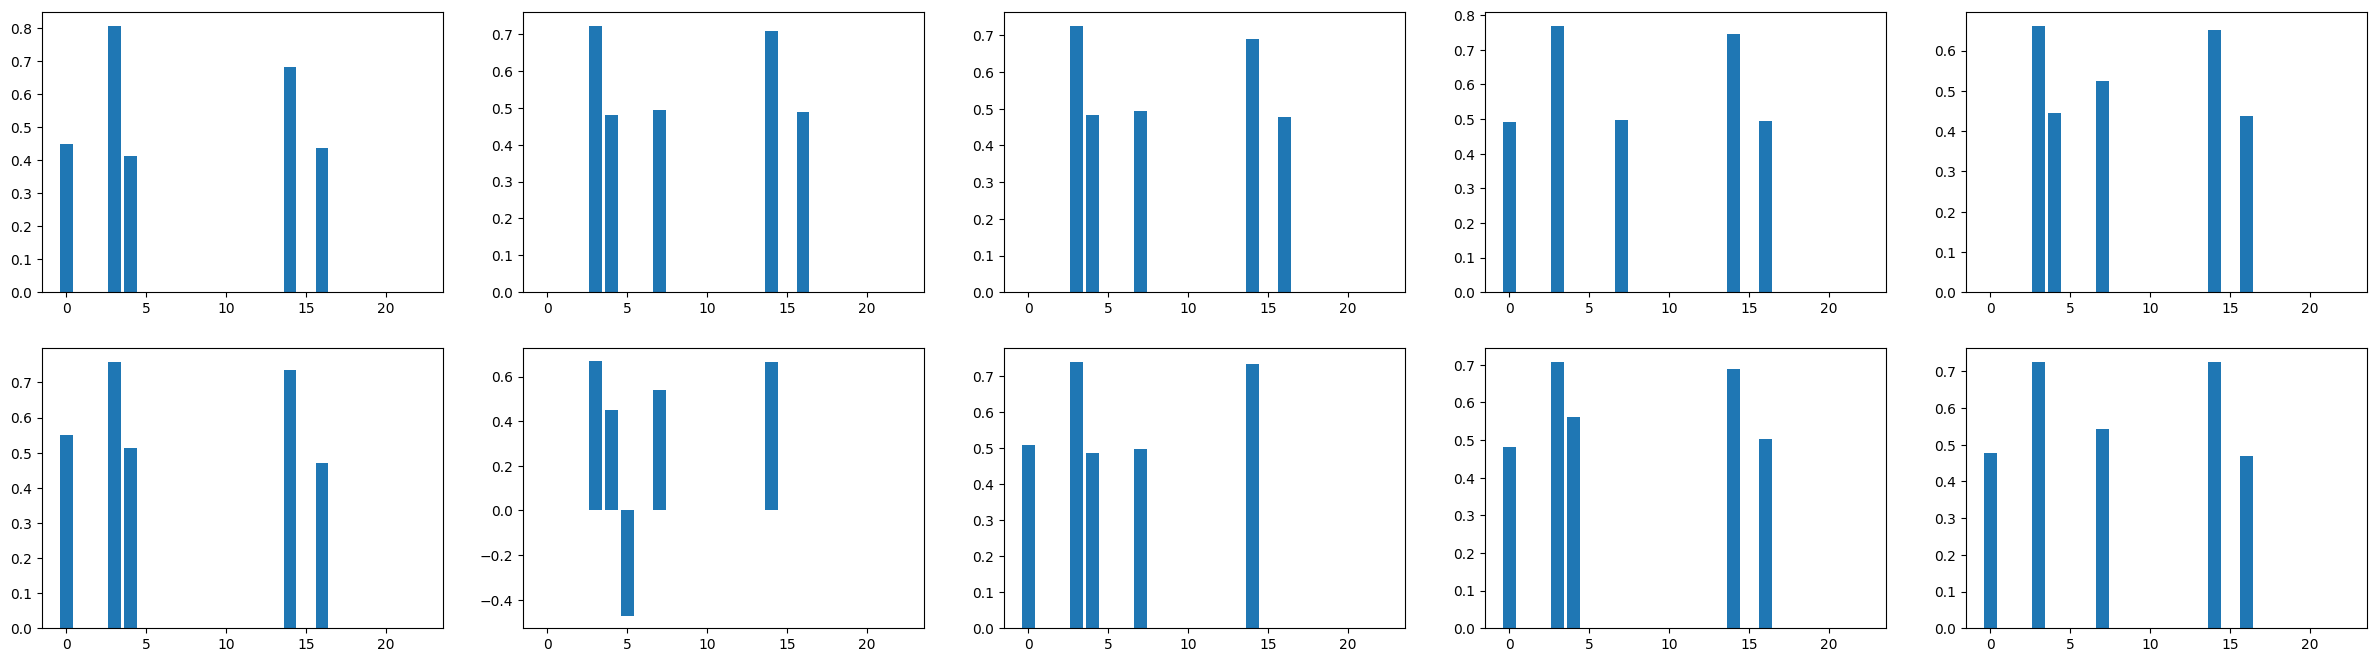

In [16]:
plot_grads(pert_grads[:10, 0], nrows=2, ncols=5, k=5)

# Multiple Models

In [20]:
ensemble_size = 20
sigma = 0.1
n_samples = 100
model_idx = np.random.choice(n_models, ensemble_size, replace=False)
grads = np.array([np.load(f'{directory}/grads_{idx}.npy') for idx in model_idx])
preds = np.array([np.load(f'{directory}/preds_{idx}.npy') for idx in model_idx])
model_idx

array([194, 957, 466,  70,   2, 606, 130, 954, 238, 687, 226, 399, 438,
       352, 896,  49, 983, 467, 580, 490])

In [23]:
noisy_grads = np.zeros((n_samples, *grads.shape))
noisy_preds = np.zeros((n_samples, *preds.shape))
layer_str = 'network.0.weight'
for j in tqdm(range(len(model_idx))):
    for i in range(n_samples):
        model = model_class(*model_args)
        state_dict = torch.load(f'{directory}/model_{model_idx[j]}.pth')
        # Add noise to layer weights
        state_dict[layer_str] += torch.randn(state_dict[layer_str].shape) * sigma
        model.load_state_dict(state_dict)

        # Compute positive class softmax prediction gradient wrt input (softmax=False for logit output)
        noisy_grads[i, j] = model.compute_gradients(X_test, softmax=False, label=1, return_numpy=True)
        noisy_preds[i, j] = model.predict(X_test, return_numpy=True)

100%|██████████| 20/20 [00:08<00:00,  2.33it/s]


In [344]:
tk, s = get_top_k(5, grads, return_sign=True)
sa = average_pairwise_score(tk, s, top_k_sa)
tk_smooth, s_smooth = get_top_k(5, noisy_grads.mean(axis=0), return_sign=True)
sa_smooth = average_pairwise_score(tk_smooth, s_smooth, top_k_sa)

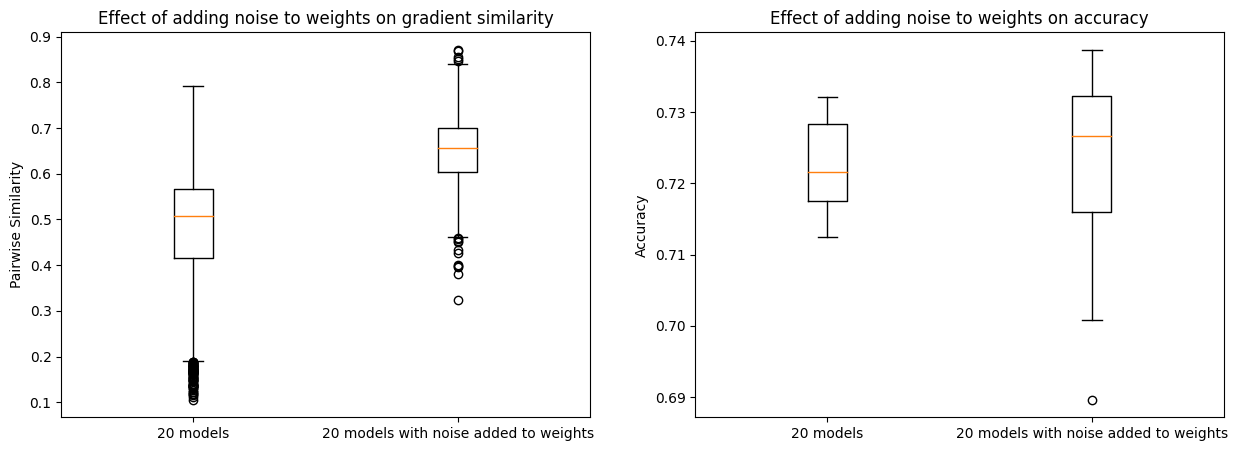

In [345]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].boxplot([sa, sa_smooth], labels=['20 models', '20 models with noise added to weights'])
ax[0].set_title('Effect of adding noise to weights on gradient similarity')
ax[0].set_ylabel('Pairwise Similarity')

smooth_preds = np.where(noisy_preds.mean(axis=0) > 0.5, 1, 0)
smooth_acc = (smooth_preds==y_test).mean(axis=1)
orig_acc = (preds==y_test).mean(axis=1)
ax[1].boxplot([orig_acc, smooth_acc], labels=['20 models', '20 models with noise added to weights'])
ax[1].set_title('Effect of adding noise to weights on accuracy')
ax[1].set_ylabel('Accuracy')

plt.show()

In [353]:
ensemble_preds = np.where(preds.mean(axis=0) > 0.5, 1, 0)
smooth_ensemble_preds = np.where(smooth_preds.mean(axis=0) > 0.5, 1, 0)
(ensemble_preds==y_test).mean(), (smooth_ensemble_preds==y_test).mean()

(0.7296202531645569, 0.7326582278481013)

# Ablations

In [171]:
# Average of all 1000 trained models
sigmas = np.logspace(-2, -0.3, 10)
grads_gt = np.array([np.load(f'{directory}/grads_{idx}.npy') for idx in range(n_models)]).mean(axis=0)
grads_gt.shape, sigmas

((1975, 23),
 array([0.01      , 0.01544859, 0.0238659 , 0.03686945, 0.05695811,
        0.08799225, 0.13593564, 0.21000142, 0.32442261, 0.50118723]))

### Effect of $\sigma$ (perturb one model)

In [172]:
model = load_model(0)
grads = model.compute_gradients(X_test, return_numpy=True)
grads.shape

(1975, 23)

In [173]:
perturb_layers = ['network.0.weight']
n_samples = 100
pert_grads = np.zeros((len(sigmas), n_samples, n_inputs, n_features))
pert_logits = np.zeros((len(sigmas), n_samples, n_inputs, 2))
for i, sigma in enumerate(tqdm(sigmas)):
    pert_model = TabularModelPerturb(model, n_samples, sigma, perturb_layers=perturb_layers)
    pert_grads[i] = pert_model.compute_gradients(X_test, mean=False)
    pert_logits[i] = pert_model.compute_logits(X_test, mean=False)
accs = (pert_logits.argmax(3)==y_test).mean(axis=2)
accs_mean = (pert_logits.mean(axis=1).argmax(2)==y_test).mean(axis=1)

100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


In [174]:
topk_og, signs_og = get_top_k(5, grads, return_sign=True)
topk_gt, signs_gt = get_top_k(5, grads_gt, return_sign=True)
topk_mean, signs_mean = get_top_k(5, pert_grads.mean(axis=1), return_sign=True)
topk, signs = get_top_k(5, pert_grads, return_sign=True)

# Similarity
sa_gt = np.zeros((len(sigmas), n_inputs))
sa_og = np.zeros((len(sigmas), n_inputs))
for i in tqdm(range(len(sigmas))):
    sa_gt[i] = average_ground_truth_score(topk[i], signs[i], topk_gt, signs_gt, top_k_sa)
    sa_og[i] = average_ground_truth_score(topk[i], signs[i], topk_og, signs_og, top_k_sa)
sa_mean_gt = ground_truth_score(topk_mean, signs_mean, topk_gt, signs_gt, top_k_sa)
sa_mean_og = ground_truth_score(topk_mean, signs_mean, topk_og, signs_og, top_k_sa)

100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


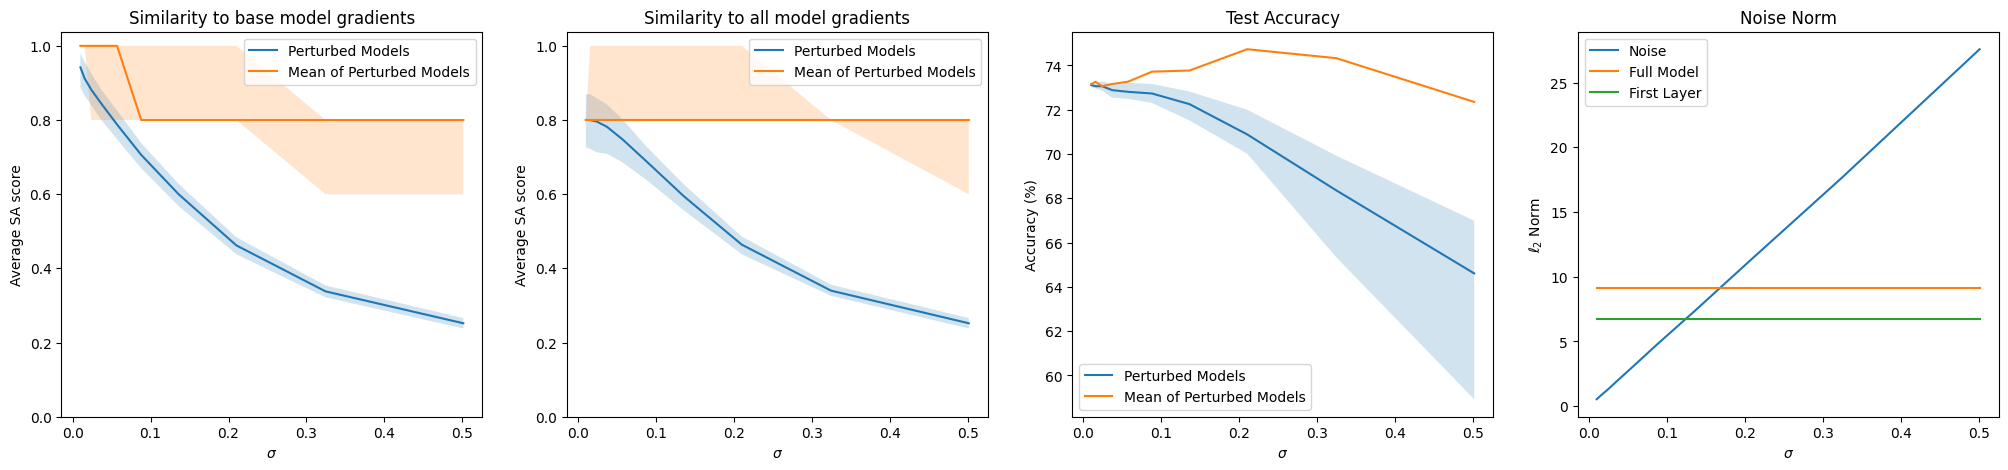

In [175]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(25, 5), dpi=100)
sas = [[sa_og, sa_mean_og], [sa_gt, sa_mean_gt]]
titles = ['Similarity to base model gradients',
          'Similarity to all model gradients',
          'Test Accuracy',
          'Noise Norm']
labels = ['Individual Perturbation', 'Mean of Perturbations (Perturbed Model)']
layer_weights = model.state_dict()[perturb_layers[0]]
noise = [torch.randn_like(layer_weights) * sigma for sigma in sigmas]
for i in range(4):
    if i == 3:
        ax[i].plot(sigmas, [n.norm().item() for n in noise], label='Noise')
        ax[i].plot(sigmas, [get_weight_norm(model.state_dict())]*len(sigmas), label='Full Model')
        ax[i].plot(sigmas, [(model.state_dict()[perturb_layers[0]]).norm()]*len(sigmas), label='First Layer')
        ax[i].set_ylabel('$\ell_2$ Norm')
    elif i == 2:
        q = np.quantile(accs*100, [0.25, 0.5, 0.75], axis=1)
        ax[i].plot(sigmas, q[1], label=labels[0])
        ax[i].fill_between(sigmas, q[0], q[2], alpha=0.2)
        ax[i].plot(sigmas, accs_mean*100, label=labels[1])
        ax[i].set_ylabel('Accuracy (%)')
    else:
        for j in range(2):
            q = np.quantile(sas[i][j], [0.25, 0.5, 0.75], axis=1)
            ax[i].plot(sigmas, q[1], label=labels[j])
            ax[i].fill_between(sigmas, q[0], q[2], alpha=0.2)
            ax[i].set_yticks(np.arange(0, 1.01, 0.2))
        ax[i].set_ylabel('Average SA score')
    ax[i].set_xlabel('$\sigma$')
    ax[i].set_title(titles[i])
    ax[i].legend()
plt.show()

### Effect of $\sigma$ (perturb multiple models)

In [181]:
n_trials = 20
model_idx = np.random.choice(n_models, n_trials, replace=False)
model_idx

In [177]:
perturb_layers = ['network.0.weight']
n_samples = 100
pert_grads = np.zeros((len(sigmas), len(model_idx), n_inputs, n_features))
pert_logits = np.zeros((len(sigmas), len(model_idx), n_inputs, 2))
for j, m_idx in enumerate(tqdm(model_idx)):
    model = load_model(m_idx)
    for i, sigma in enumerate(sigmas):
        pert_model = TabularModelPerturb(model, n_samples, sigma, perturb_layers=perturb_layers)
        pert_grads[i,j] = pert_model.compute_gradients(X_test, mean=True)
        pert_logits[i,j] = pert_model.compute_logits(X_test, mean=True)
accs = (pert_logits.argmax(3)==y_test).mean(axis=2)
accs_mean = (pert_logits.mean(axis=1).argmax(2)==y_test).mean(axis=1)

100%|██████████| 20/20 [00:57<00:00,  2.89s/it]


In [178]:
topk_og, signs_og = get_top_k(5, grads, return_sign=True)
topk_gt, signs_gt = get_top_k(5, grads_gt, return_sign=True)
topk_mean, signs_mean = get_top_k(5, pert_grads.mean(axis=1), return_sign=True)
topk, signs = get_top_k(5, pert_grads, return_sign=True)

# Similarity
sa_gt = np.zeros((len(sigmas), n_inputs))
sa_og = np.zeros((len(sigmas), n_inputs))
for i in tqdm(range(len(sigmas))):
    sa_gt[i] = average_ground_truth_score(topk[i], signs[i], topk_gt, signs_gt, top_k_sa)
    sa_og[i] = average_ground_truth_score(topk[i], signs[i], topk_og, signs_og, top_k_sa)
sa_mean_gt = ground_truth_score(topk_mean, signs_mean, topk_gt, signs_gt, top_k_sa)
sa_mean_og = ground_truth_score(topk_mean, signs_mean, topk_og, signs_og, top_k_sa)

100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


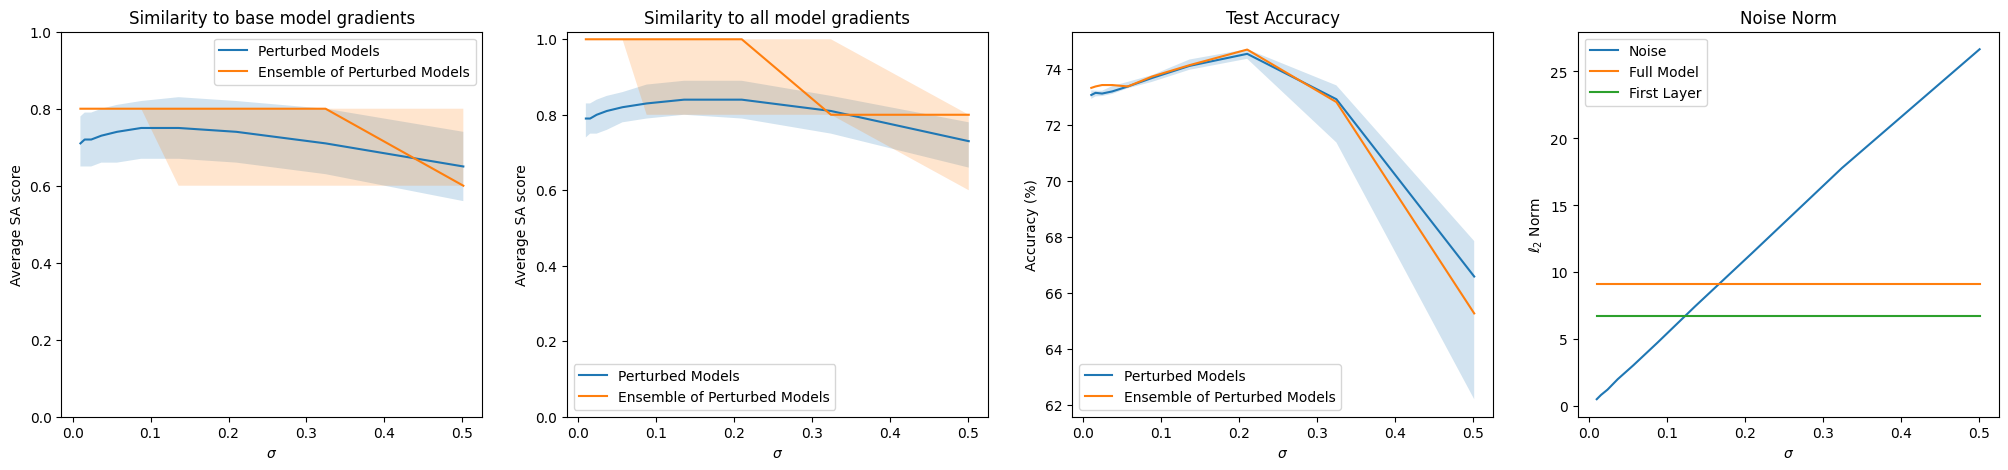

In [183]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(25, 5), dpi=100)
sas = [[sa_og, sa_mean_og], [sa_gt, sa_mean_gt]]
titles = ['Similarity to base model gradients',
          'Similarity to all model gradients',
          'Test Accuracy',
          'Noise Norm']
labels = ['Perturbed Models', 'Ensemble of Perturbed Models']
layer_weights = model.state_dict()[perturb_layers[0]]
noise = [torch.randn_like(layer_weights) * sigma for sigma in sigmas]
for i in range(4):
    if i == 3:
        ax[i].plot(sigmas, [n.norm().item() for n in noise], label='Noise')
        ax[i].plot(sigmas, [get_weight_norm(model.state_dict())]*len(sigmas), label='Full Model')
        ax[i].plot(sigmas, [(model.state_dict()[perturb_layers[0]]).norm()]*len(sigmas), label='First Layer')
        ax[i].set_ylabel('$\ell_2$ Norm')
    elif i == 2:
        q = np.quantile(accs*100, [0.25, 0.5, 0.75], axis=1)
        ax[i].plot(sigmas, q[1], label=labels[0])
        ax[i].fill_between(sigmas, q[0], q[2], alpha=0.2)
        ax[i].plot(sigmas, accs_mean*100, label=labels[1])
        ax[i].set_ylabel('Accuracy (%)')
    else:
        for j in range(2):
            q = np.quantile(sas[i][j], [0.25, 0.5, 0.75], axis=1)
            ax[i].plot(sigmas, q[1], label=labels[j])
            ax[i].fill_between(sigmas, q[0], q[2], alpha=0.2)
            ax[i].set_yticks(np.arange(0, 1.01, 0.2))
        ax[i].set_ylabel('SA score')
    ax[i].set_xlabel('$\sigma$')
    ax[i].set_title(titles[i])
    ax[i].legend()
plt.show()

### Effect of $\sigma$ and number of perturbations (similarity between ensembles)

In [305]:
5/np.sqrt(64*128)

0.05524271728019902

In [384]:
perturb_layers = ['network.0.weight']
n_trials = 20
ensemble_size = 1
n_samples = [10, 20, 50, 100, 200]
sigmas = np.logspace(-2, -0.3, 20)
sigmas

array([0.01      , 0.01228779, 0.01509897, 0.0185533 , 0.02279789,
       0.02801357, 0.03442248, 0.04229761, 0.0519744 , 0.06386504,
       0.078476  , 0.09642964, 0.11849069, 0.14559883, 0.17890875,
       0.21983926, 0.27013381, 0.33193468, 0.40787428, 0.50118723])

In [385]:
pert_grads = np.zeros((len(sigmas), len(n_samples), n_trials, n_inputs, n_features))
pert_logits = np.zeros((len(sigmas), len(n_samples), n_trials, n_inputs, 2))
for j in tqdm(range(n_trials)):
    model_idx = np.random.choice(n_models, ensemble_size, replace=False)
    models = [load_model(i) for i in model_idx]
    for i, sigma in enumerate(sigmas):
        for model in models:
            pert_model = TabularModelPerturb(model, n_samples[-1], sigma, perturb_layers=perturb_layers)
            p_grads = pert_model.compute_gradients(X_test, mean=False)
            p_logits = pert_model.compute_logits(X_test, mean=False)
            for l, n in enumerate(n_samples):
                pert_grads[i,l,j] += p_grads[:n].mean(axis=0)
                pert_logits[i,l,j] += p_logits[:n].mean(axis=0)
pert_grads /= ensemble_size
pert_logits /= ensemble_size
accs = (pert_logits.argmax(-1)==y_test).mean(axis=-1)
accs_mean = (pert_logits.mean(axis=-3).argmax(-1)==y_test).mean(axis=-1)

100%|██████████| 20/20 [04:21<00:00, 13.07s/it]


In [386]:
topk, signs = get_top_k(5, pert_grads, return_sign=True)
sa = np.zeros((len(sigmas), len(n_samples), n_inputs))
for i in tqdm(range(len(sigmas))):
    for j in range(len(n_samples)):
        sa[i,j] = average_pairwise_score(topk[i,j], signs[i,j], top_k_sa)

100%|██████████| 20/20 [04:00<00:00, 12.01s/it]


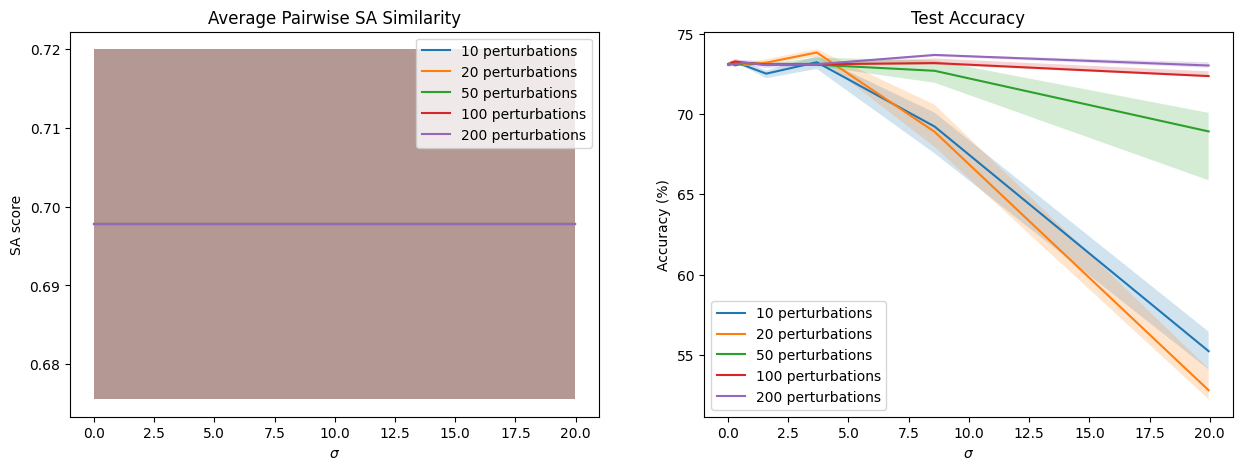

In [356]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=100)
metrics = [sa, accs*100]
titles = ['Average Pairwise SA Similarity',
          'Test Accuracy']
ylabels = ['SA score', 'Accuracy (%)']

for i in range(2):
    for j in range(len(n_samples)):
        q = np.quantile(metrics[i][:,j], [0.4, 0.5, 0.6], axis=-1)
        ax[i].plot(sigmas, q[1], label=f'{n_samples[j]} perturbations')
        ax[i].fill_between(sigmas, q[0], q[2], alpha=0.2)
    ax[i].set_xlabel('$\sigma$')
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_title(titles[i])
    ax[i].legend()
plt.show()

### Multiple Layers

In [255]:
# Get names of all layers
layer_names = [name for name, _ in model.named_parameters()]
layer_titles = ['Layer ' + str(int(layer_names.split('.')[1])//2+1) + ' ' + layer_names.split('.')[-1].title() for layer_names in layer_names]
layer_weights = [model.state_dict()[name] for name in layer_names]
layer_norms = [lw.norm().item() for lw in layer_weights]
layer_norms_cum = list(np.cumsum(layer_norms))
print(layer_names)
print(layer_titles)

['network.0.weight', 'network.0.bias', 'network.2.weight', 'network.2.bias', 'network.4.weight', 'network.4.bias', 'network.6.weight', 'network.6.bias']
['Layer 1 Weight', 'Layer 1 Bias', 'Layer 2 Weight', 'Layer 2 Bias', 'Layer 3 Weight', 'Layer 3 Bias', 'Layer 4 Weight', 'Layer 4 Bias']


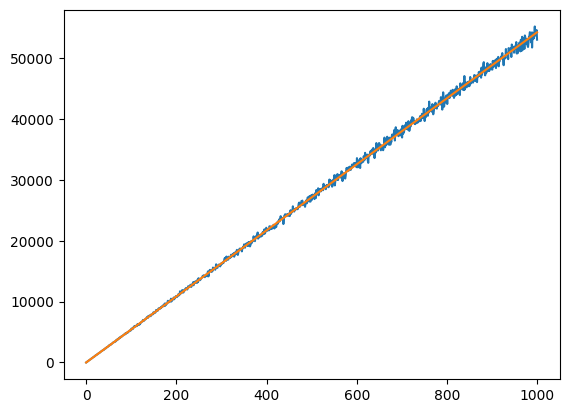

In [275]:
sigs = np.linspace(0, 1000, 1000)
nos = [torch.randn_like(layer_weights[0]) * sig for sig in sigs]
no_norms = [no.norm().item() for no in nos]
plt.plot(sigs, no_norms)
n_connect = layer_weights[0].flatten().shape[0]
plt.plot(sigs, sigs*np.sqrt(n_connect))
plt.show()

In [ ]:
optimal_sigmas = [0.2, 0.8,
                  0.05, 1.0,
                  0 to 0.5, 1.5,
                  0 to 10, 0 to 10]

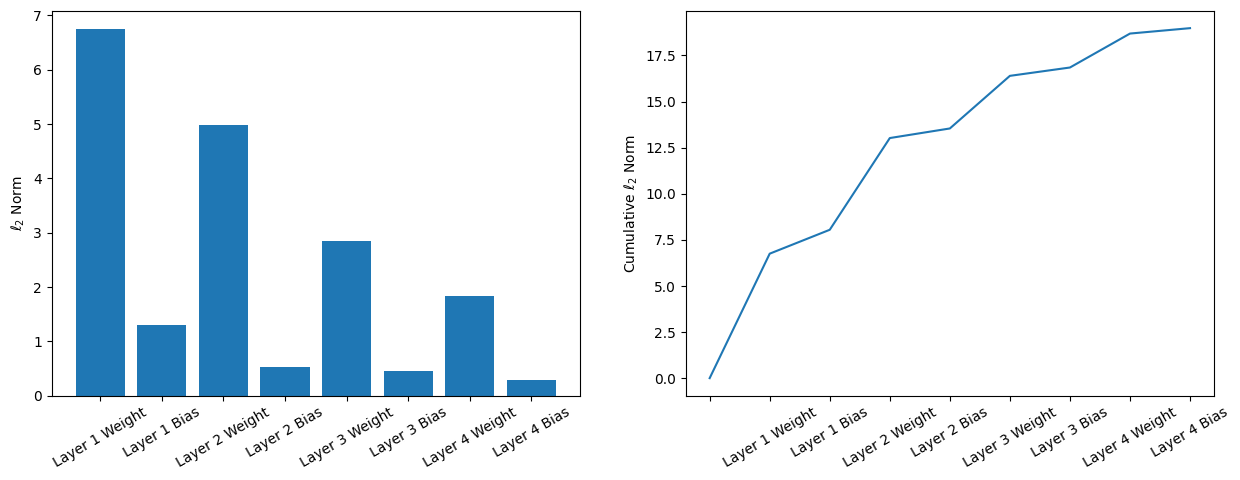

In [256]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=100)

ax[0].bar(np.arange(len(layer_names)), layer_norms)
ax[0].set_xticks(np.arange(len(layer_names)), layer_titles, rotation=30)
ax[0].set_ylabel('$\ell_2$ Norm')

ax[1].plot([0]+layer_norms_cum)
ax[1].set_xticks(np.arange(len(layer_names)+1), ['']+layer_titles, rotation=30)
ax[1].set_ylabel('Cumulative $\ell_2$ Norm')
plt.show()

In [357]:
n_samples = 50
sigma = 0.2
n_trials = 10
model = load_model(0)
pert_grads = np.zeros((len(layer_names), n_trials, n_inputs, n_features))
pert_logits = np.zeros((len(layer_names), n_trials, n_inputs, 2))
for i in tqdm(range(len(layer_names))):
    perturb_layers = layer_names[:i+1]
    for j in range(n_trials):
        pert_model = TabularModelPerturb(model, n_samples, sigma,
                                         perturb_layers=perturb_layers)
        pert_grads[i,j] = pert_model.compute_gradients(X_test, mean=True)
        pert_logits[i,j] = pert_model.compute_logits(X_test, mean=True)
accs = (pert_logits.argmax(axis=-1)==y_test).mean(axis=-1)

100%|██████████| 8/8 [00:53<00:00,  6.65s/it]


In [363]:
topk, signs = get_top_k(5, pert_grads, return_sign=True)
sa = np.zeros((len(layer_names), n_inputs))
for i in tqdm(range(len(layer_names))):
    sa[i] = average_pairwise_score(topk[i], signs[i], top_k_sa)

100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


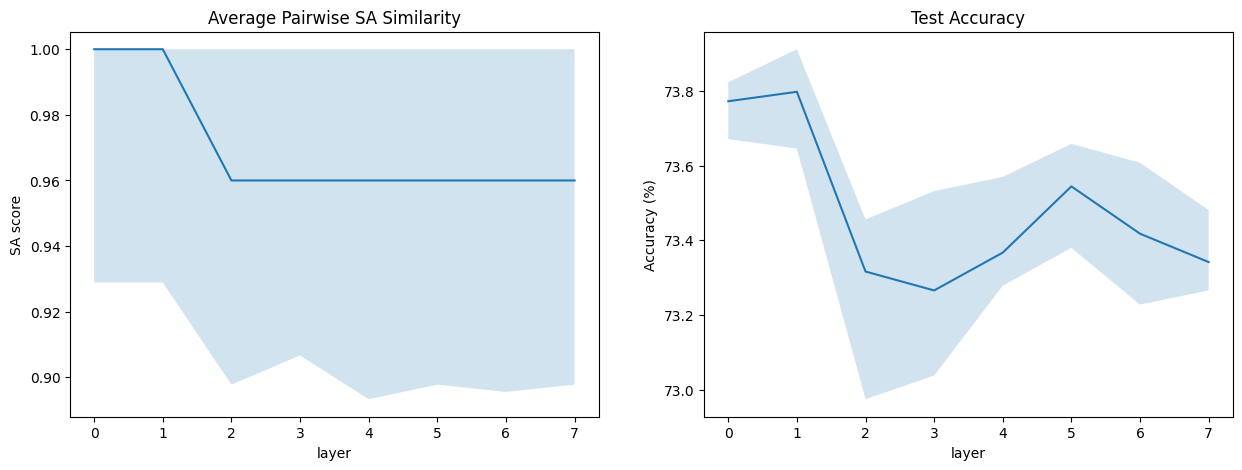

In [377]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=100)
metrics = [sa, accs*100]
titles = ['Average Pairwise SA Similarity',
          'Test Accuracy']
ylabels = ['SA score', 'Accuracy (%)']

for i in range(2):
    q = np.quantile(metrics[i], [0.25, 0.5, 0.75], axis=-1)
    ax[i].plot(range(len(layer_names)), q[1])
    ax[i].fill_between(range(len(layer_names)), q[0], q[2], alpha=0.2)
    ax[i].set_xlabel('layer')
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_title(titles[i])
plt.show()

In [33]:
topk_gt, signs_gt = get_top_k(5, grads, return_sign=True)
topk, signs = get_top_k(5, pert_grads, return_sign=True)
gt_sa = np.zeros((len(layer_names), n_inputs))
for i in tqdm(range(len(layer_names))):
    gt_sa[i] = average_ground_truth_score(topk[i], signs[i], topk_gt, signs_gt, top_k_sa)

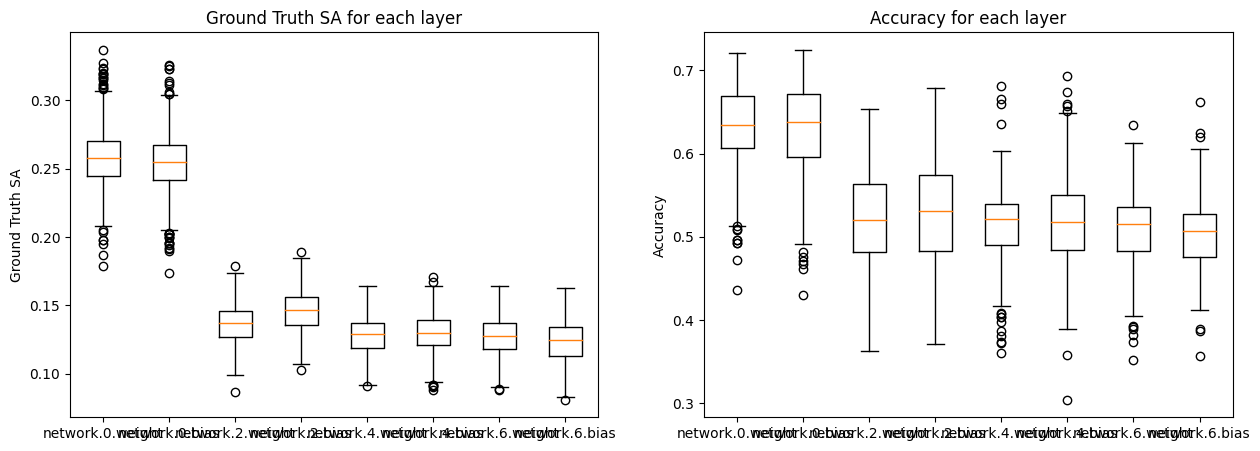

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
titles = ['Ground Truth SA', 'Accuracy']
for i, metric in enumerate([gt_sa, accs]):
    ax[i].boxplot([metric[i] for i in range(len(layer_names))], labels=layer_names)
    #ax[i].set_xticks(rotation=30)
    ax[i].set_ylabel(titles[i])
    ax[i].set_title(f'{titles[i]} for each layer')
plt.show()

### Number of perturbations

# TODO:
# - Optimize perturbation method